# Принятие решений в бизнесе

## Описание проекта

В данном проекте мы будем анализировать показатели интернет-магазина. Вместе с отделом маркетинга мы подготовили список гипотез для увеличения выручки.

**Цель** — провести А/В-тест и предложить рекомендации для бизнеса.

**Задачи**:
1.   Приоритизировать гипотезы (способами ICE, RICE);
2.   Запустить A/B-тест;
3. Проанализировать результаты.

**Описание данных**:

Структура hypothesis.csv
- `Hypothesis` — краткое описание гипотезы;
- `Reach` — охват пользователей по 10-балльной шкале;
- `Impact` — влияние на пользователей по 10-балльной шкале;
- `Confidence` — уверенность в гипотезе по 10-балльной шкале;
- `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение `Efforts`, тем дороже проверка гипотезы.

Структура orders.csv
- `transactionId` — идентификатор заказа;
- `visitorId` — идентификатор пользователя, совершившего заказ;
- `date` — дата, когда был совершён заказ;
- `revenue` — выручка заказа;
- `group` — группа A/B-теста, в которую попал заказ.

Структура visitors.csv
- `date` — дата;
- `group` — группа A/B-теста;
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

## Предобработка данных

### Получение данных

In [1]:
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import math as mth
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
hypothesis = pd.read_csv('/content/drive/My Drive/Colab Notebooks Files/hypothesis.csv')
orders = pd.read_csv('/content/drive/My Drive/Colab Notebooks Files/orders.csv')
visitors = pd.read_csv('/content/drive/My Drive/Colab Notebooks Files/visitors.csv')

In [4]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [5]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [6]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


### Типы данных

Приведем столбцы с датами к корректному типу данных.

In [7]:
orders["date"] = pd.to_datetime(orders["date"])
visitors["date"] = pd.to_datetime(visitors["date"])

### Общие выводы по главе

В ходе предобработки мы заменили типы данных в таблицах orders и visitors. В остальном проблем (пропусков, дубликатов) не обнаружено, можно приступать к анализу.

## Приоритизация гипотез

Выведем список гипотез, чтобы иметь его перед глазами во время анализа.

In [26]:
pd.set_option('display.max_colwidth', 700)
hypothesis['Hypothesis']

0              Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
1                                       Запустить собственную службу доставки, что сократит срок доставки заказов
2    Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
3             Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар
4                                Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей
5                        Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов
6            Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию
7                Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
8                                                         Запустить акцию, дающую скидку

### Применение фреймворка ICE

ICE (влияние, уверенность, усилия) — один из популярных способов приоритизации задач.

ICE score = (Impact x Confidence) / Efforts

Применим фреймворк и отсортируем результат по убыванию приоритета.

In [9]:
hypothesis['ICE'] = round((hypothesis['Impact'] * hypothesis['Confidence']) / hypothesis['Efforts'], 1)
hypothesis.sort_values(by = 'ICE', ascending=False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5,16.2
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6,13.3
7,Добавить форму подписки на все основные страни...,10,7,8,5,11.2
6,Показать на главной странице баннеры с актуаль...,5,3,8,3,8.0
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3,7.0
1,"Запустить собственную службу доставки, что сок...",2,5,4,10,2.0
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3,1.3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8,1.1
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1,1.0


Гипотеза '**Запустить акцию, дающую скидку на товар в день рождения**' оказалась на первом месте. 

Также неплохо выглядят гипотезы '**Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей**' и '***Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок***'. Остальные имеют крайне низкие значения приоритета.

### Применение фреймворка RICE

RICE (влияние, уверенность, усилия, охват) — это модификация предыдущего фреймворка. Здесь появляется параметр охвата аудитории, т.е. скольких пользователей затронет изменение.

RICE score = (Reach x Impact x Confidence) / Efforts

In [10]:
hypothesis['RICE'] = (hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence']) / hypothesis['Efforts']
hypothesis.sort_values(by = 'RICE', ascending=False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
7,Добавить форму подписки на все основные страни...,10,7,8,5,11.2,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3,7.0,56.0
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6,13.3,40.0
6,Показать на главной странице баннеры с актуаль...,5,3,8,3,8.0,40.0
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5,16.2,16.2
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8,1.1,9.0
1,"Запустить собственную службу доставки, что сок...",2,5,4,10,2.0,4.0
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3,1.3,4.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1,1.0,3.0


В данном случае на первом месте оказалась гипотеза '**Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок**'.

Второе и третье место достались гипотезам '**Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа**' и '**Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей**' соответственно.

### Интерпретация результатов

Разница между двумя результатами связана с тем, что гипотеза '**Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок**' не только обладает относительно высоким приоритетом, но и распространяется на значительное число пользователей. Связь между параметром Reach и результатом фреймворка RICE хорошо видна в таблице ниже.

In [11]:
hypothesis[['Hypothesis', 'Reach', 'RICE']].sort_values(by='RICE', ascending=False)

,Hypothesis,Reach,RICE
7,Добавить форму подписки на все основные страни...,10,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,8,56.0
0,"Добавить два новых канала привлечения трафика,...",3,40.0
6,Показать на главной странице баннеры с актуаль...,5,40.0
8,"Запустить акцию, дающую скидку на товар в день...",1,16.2
3,"Изменить структура категорий, что увеличит кон...",8,9.0
1,"Запустить собственную службу доставки, что сок...",2,4.0
5,"Добавить страницу отзывов клиентов о магазине,...",3,4.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3,3.0


## Анализ A/B-теста

### График кумулятивной выручки по группам

In [28]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

print(cumulativeData.head(5))

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      24      20   148579       719
1 2019-08-01     B      21      20   101217       713
2 2019-08-02     A      44      38   242401      1338
3 2019-08-02     B      45      43   266748      1294
4 2019-08-03     A      68      62   354874      1845


Теперь посмотрим, нет ли пользователей, которые оказались сразу в двух группах поскольку сделали несколько заказов.

In [73]:
new_ordersA = orders.loc[orders['group'] == 'A', 'visitorId']
new_ordersB = orders.loc[orders['group'] == 'B', 'visitorId']
print('Примеры пользователей, которые оказались в обеих группах: ', list(set(new_ordersA) & set(new_ordersB))[0:5])
print()
print('Общее количество таких пользователей: ', len(list(set(new_ordersA) & set(new_ordersB))))

Примеры пользователей, которые оказались в обеих группах:  [3957174400, 3984495233, 2780786433, 1294878855, 1648269707]

Общее количество таких пользователей:  58


In [74]:
#возьмем первого пользователя из предложенных и проверим принадлежность к группам
orders.loc[orders['visitorId'] == 3957174400]

,transactionId,visitorId,date,revenue,group
269,1067267410,3957174400,2019-08-18,2480,A
561,3241914033,3957174400,2019-08-26,2480,B


Выяснилось, что такие пользователи есть, всего их 58. Это значит, что инструмент «деления» трафика работает с ошибками. Такие пользователи могут увидеть обе стороны А/B теста, что негативно скажется на результатах. Следует принимать это во внимание.

Теперь построим график, на котором отобразим кумулятивную выручку обеих групп за указанный период.

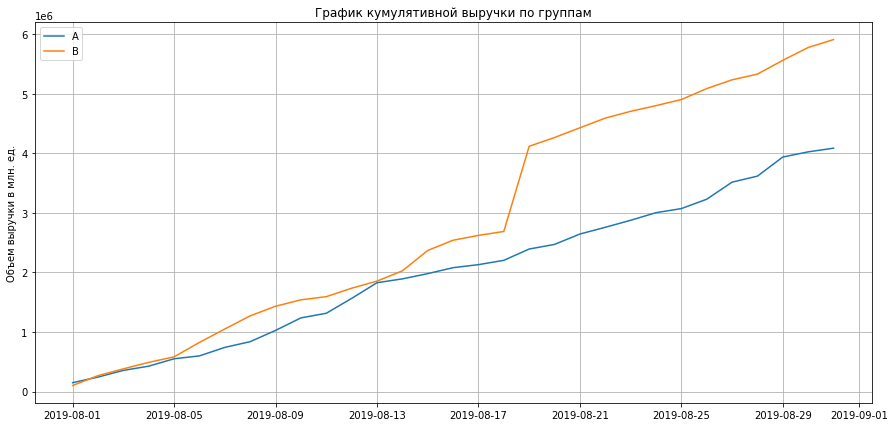

In [79]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
plt.figure(figsize=(15, 7))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.title('График кумулятивной выручки по группам')
plt.ylabel('Объем выручки в млн. ед.')
plt.grid()
plt.legend() 

Мы видим, что до 13 августа обе группы демонстрировали примерно одинаковый уровень выручки, но затем группа Б вышла в отрыв и закрепилась на более высоком уровне к концу августа. Остается непонятным следующее: насколько реалистичен резкий подъем выручки за короткий срок?

Проверим разброс значений дневной выручки в группе Б.

In [80]:
ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

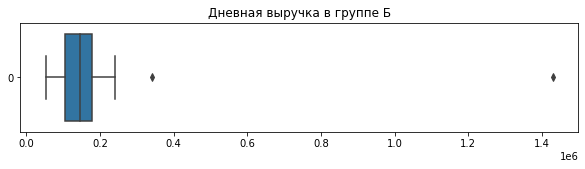

In [81]:
plt.figure(figsize=(10, 2))
ax = sns.boxplot(data = ordersBDaily['revenuePerDateB'], orient="h")
ax.set(title ='Дневная выручка в группе Б');

In [82]:
ordersBDaily['revenuePerDateB'].sort_values(ascending=False).head()

18    1429920
14     342499
5      242342
28     231130
6      225334
Name: revenuePerDateB, dtype: int64

Как мы видим, 19 августа дневная выручка многократно увеличилась относительно медианной. Осталось определить, какое количество заказов так повлияли на статистику.

In [83]:
orders.query('date == "2019-08-19" & group == "B"').sort_values(by='revenue', ascending=False).head()

,transactionId,visitorId,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
527,1570513684,2837914161,2019-08-19,33405,B
461,2683113224,154576532,2019-08-19,26550,B
368,3268879337,2536252163,2019-08-19,20026,B
463,4170537404,290022471,2019-08-19,16480,B


Выяснилось, что это был один заказ c id 590470918, который сильно изменил общую картину. Это очевидный выброс и его не следует учитывать при анализе всей совокупности заказов.

### График кумулятивного среднего чека по группам

Средний чек можно найти, разделив выручку на количество заказов.

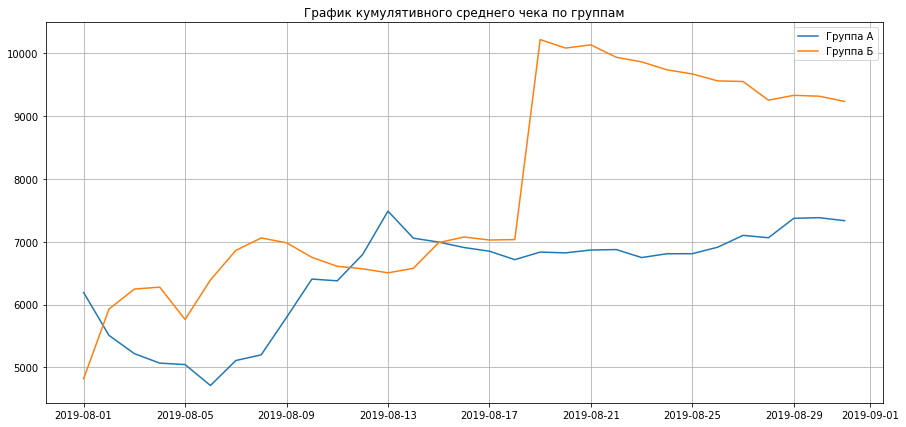

In [84]:
plt.figure(figsize=(15, 7))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='Группа A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='Группа Б')
plt.title('График кумулятивного среднего чека по группам')
plt.grid()
plt.legend();

График напоминает предыдущий. Присутствует уже известный нам скачок 19 августа. Главное отличие в том, что этот крупный заказ резко увеличил средний чек, который затем начал "возвращаться" в предыдущее положение. Интересно, что группы А и Б демонстрируют противоположную динамику к концу месяца.

### График относительного изменения кумулятивного среднего чека группы B к группе A

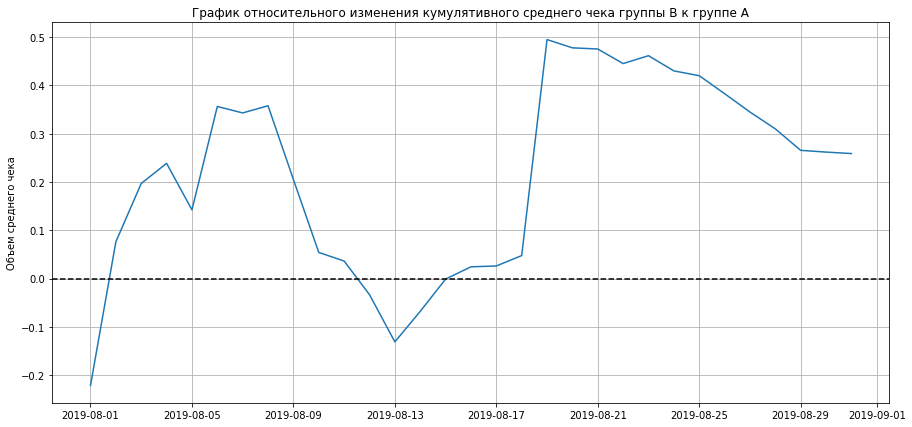

In [85]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.figure(figsize=(15, 7))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.ylabel('Объем среднего чека')
plt.grid();

График условно можно разбить две части: до и после 13 августа. Мы видим, что заказ 19 августа сильно повлиял на общую динамику кумулятивного среднего чека. В целом, к концу месяца группа B опережает своего соперника, но размер чека возвращается к своим прежним значениям, поэтому судить пока рано.

### График кумулятивного среднего количества заказов на посетителя по группам

Среднее количество заказов на посетителя по-другому называется конверсией. Итак, посчитаем конверсию и построим соответствующий график.

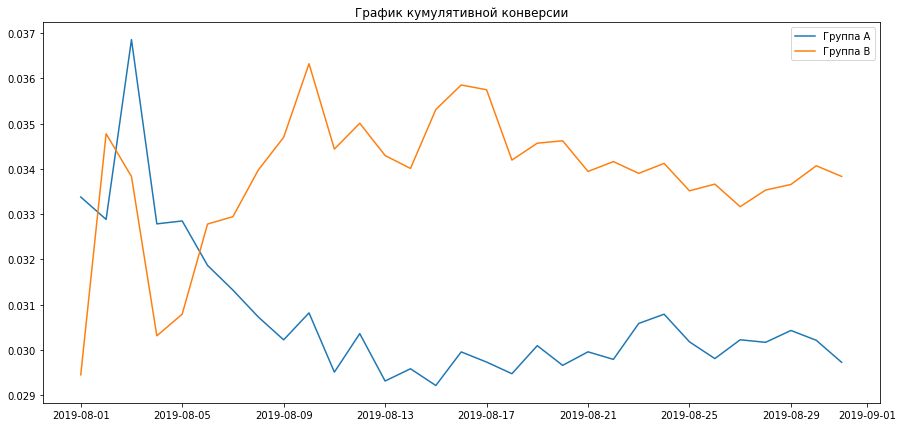

In [86]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.figure(figsize=(15, 7))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='Группа A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='Группа B')
plt.title('График кумулятивной конверсии')
plt.legend();

Из данного графика становится понятно, что конверсия колебалась в течение месяца. Ключевым моментом стал период в начале августа, где обе группы синхронно улучшали и ухудшали показали конверсии: обе были под влиянием маркетинговых кампаний того или иного рода. Затем, около 6 августа группа В обогнала соперника в данном показателе и зафиксировались на более высоком уровне.

### График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.

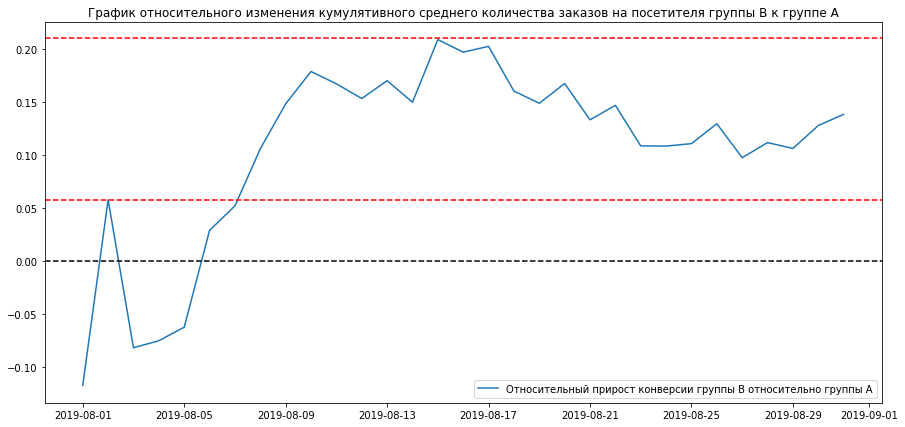

In [87]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(15, 7))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.057, color='red', linestyle='--')
plt.axhline(y=0.21, color='red', linestyle='--');

Здесь мы наблюдаем ситуацию, при которой группа В дважды за месяц достигала пиковых значений при переходе через границу (значения отмечены красной пунктирной линией): 2 и 15 августа. К концу месяца значение конверсий снижается до уровня в 15% относительно группы А.

### Точечный график количества заказов по пользователям

          userId  orders
1023  4256040402      11
591   2458001652      11
569   2378935119       9
487   2038680547       8
44     199603092       5



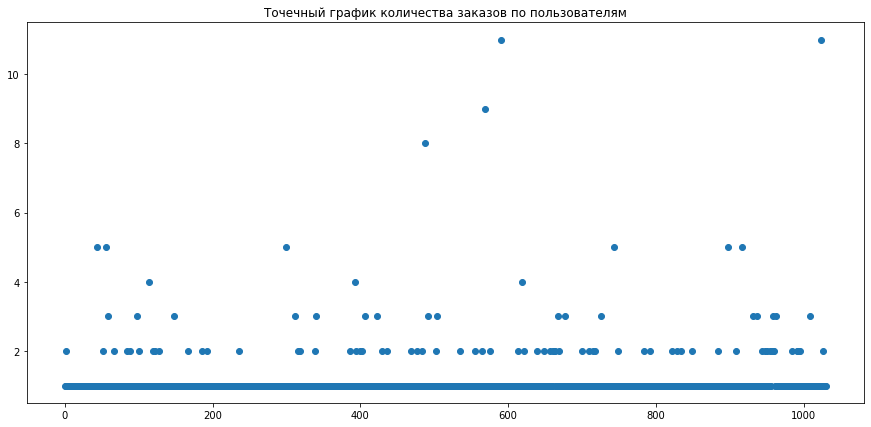

In [88]:
ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)
ordersByUsers.columns = ['userId', 'orders']

print(ordersByUsers.sort_values(by='orders', ascending=False).head(5))
print()

# серия из чисел от 0 до количества наблюдений в ordersByUsers
x_values = pd.Series(range(0, len(ordersByUsers)))

plt.figure(figsize=(15, 7))
plt.scatter(x_values, ordersByUsers['orders'])
plt.title('Точечный график количества заказов по пользователям');

Сплошная линия на графике говорит нам о том, что за данный период времени количество заказов редко когда превышало единицу. Есть относительно небольшая группа пользователей, которые в августе заказывали от 2 до 11 раз (последних было только 2 человека). Вопрос в том, можно ли эту группу считать выбросом. Для ответа на вопрос обратимся к перцентилям.

### 95-й и 99-й перцентили количества заказов на пользователя

In [89]:
print(np.percentile(ordersByUsers['orders'], [95, 99]))

[2. 4.]


Как минимум 95% пользователей делают 1-2 заказа. Это значит, что 2 заказа ещё не является аномалией.

### Точечный график стоимостей заказов

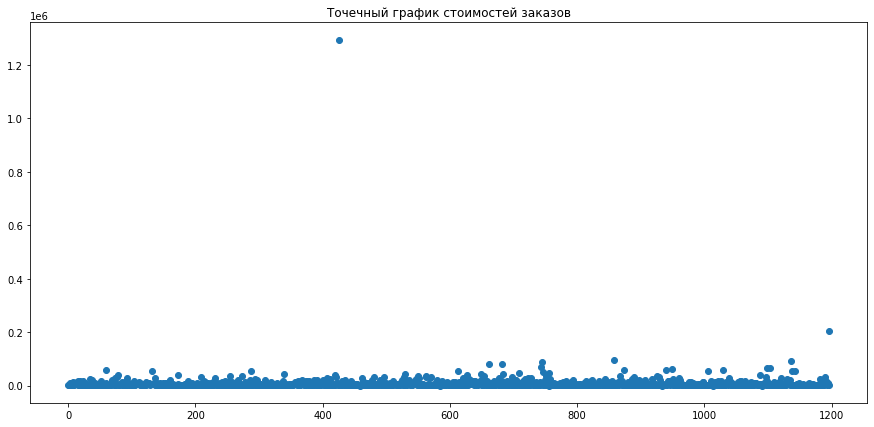

In [90]:
x_values = pd.Series(range(0, len(orders['revenue'])))

plt.figure(figsize=(15, 7))
plt.scatter(x_values, orders['revenue'])
plt.title('Точечный график стоимостей заказов');

Мы видим, что есть два сверхкрупных заказа на 200 тыс. рублей и 1 млн рублей (однозначно аномалии). При таком масштабе сложно разглядеть конкретные данные на уровне заказов до 200 000 рублей. Исправим ситуацию.

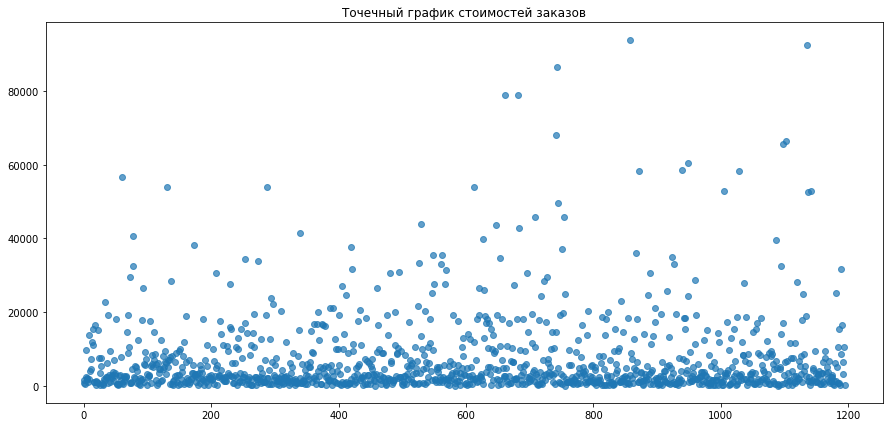

In [91]:
temp = orders.query('revenue < 200000')

x_values = pd.Series(range(0, len(temp)))

plt.figure(figsize=(15, 7))
plt.scatter(x_values, temp['revenue'], alpha=0.7)
plt.title('Точечный график стоимостей заказов');

Итак, большинство заказов имеет стоимость до 40 тыс рублей, но сказать точнее мы сможем только посчитав выборочные перцентили.

### 95-й и 99-й перцентили стоимости заказов

In [92]:
print(np.percentile(orders['revenue'], [95, 99]))

[28000.  58233.2]


Итак, 95% заказов имеет стоимость меньшую, чем 28 000 рублей.

### Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным

Для подсчета статистической значимости нам потребуются данные из разных таблиц. Аккумулируем их.

In [93]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

print(data.head(5)) 

        date  ordersPerDateA  revenuePerDateA  ordersPerDateB  \
0 2019-08-01              24           148579              21   
1 2019-08-02              20            93822              24   
2 2019-08-03              24           112473              16   
3 2019-08-04              16            70825              17   
4 2019-08-05              25           124218              23   

   revenuePerDateB  ordersCummulativeA  revenueCummulativeA  \
0           101217                  24               148579   
1           165531                  44               242401   
2           114248                  68               354874   
3           108571                  84               425699   
4            92428                 109               549917   

   ordersCummulativeB  revenueCummulativeB  visitorsPerDateA  \
0                  21               101217               719   
1                  45               266748               619   
2                  61               38

Посчитаем статистическую значимость различия в среднем количестве заказов между группами. Для этого =оздадим переменные ordersByUsersA и ordersByUsersB со столбцами ['userId', 'orders']. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.

In [94]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders']

Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули.

In [95]:
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

В sampleA сохранили выборку, где каждый элемент — число заказов определённого пользователя, в том числе ноль. Значит, число элементов sampleA — это количество пользователей, сумма всех элементов — количество заказов. Чтобы получить среднее число заказов на пользователя, поделим сумму заказов на число пользователей — найдём среднее в выборке sampleA методом mean().

Теперь обозначим нашу **нулевую гипотезу**: различий в конверсии между группами нет. **Альтернативная**: различия в среднем между группами есть.

Выведем относительный прирост среднего числа заказов группы B: среднее число заказов группы B / среднее число заказов группы A - 1. Округлим до трёх знаков после запятой.

In [96]:
print("P-value: {0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("Относительный проигрыш/выигрыш группы В к группе А: {0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

P-value: 0.017
Относительный проигрыш/выигрыш группы В к группе А: 0.138


Вывод: По «сырым» данным различия в среднем числе заказов групп A и B есть (p-value меньше 0.05). Разница составила 13.8%

### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

Выведем p-value для сравнения средних чеков между группами. Округлим p-value до трёх знаков после запятой. Затем выведем относительный прирост среднего чека группы B, округлив до трёх знаков после запятой.

Нулевая гипотеза в данном случае следующая: значимых различий в средних чеках между группами нет. **Альтернативная**: различия в средних чеках между группами есть.

In [97]:
print('p-value: {0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Относительное различие среднего чека между группами: {0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

p-value: 0.729
Относительное различие среднего чека между группами: 0.259


Как мы видим, значение p-value куда больше, чем пороговое (0.05), поэтому нулевую гипотезу не отвергаем (значимых различий нет в средних чеках). В то же время относительные различия между группами составляют 26%. Что-то здесь не так. Следует посмотреть на данные без аномалий.

### Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

Перейдем к очистке данных. Используя имеющиеся данные, мы можем принять за аномальных пользователей тех, кто совершил от 3 заказов или сделал заказ дороже 58233.2 рублей. Получим две переменные `usersWithManyOrders` и `usersWithExpensiveOrders` соответственно.

In [99]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > np.percentile(ordersByUsers['orders'], [95, 99])[0]]['visitorId'],
        ordersByUsersB[ordersByUsersB['orders'] > np.percentile(ordersByUsers['orders'], [95, 99])[0]]['visitorId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > np.percentile(orders['revenue'], [95, 99])[0]]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

Объединим данные об этих пользователях в таблице abnormalUsers и узнаем, сколько их всего атрибутом shape.

In [100]:
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print()
print("Всего аномальных пользователей:", abnormalUsers.shape[0])

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
Name: visitorId, dtype: int64

Всего аномальных пользователей: 74


Теперь узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в среднем количестве заказов между группами теста по очищенным данным. Сначала подготовим выборки количества заказов по пользователям по группам теста:

In [101]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

Применим статистический критерий Манна-Уитни к полученным выборкам.

**Нулевая гипотеза** гласит: статистически значимых различий в конверсии между группами нет. **Альтернативная гипотеза**: статистически значимые различия есть.

In [102]:
print('p=value: {0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Cтатистическая значимость различий в среднем количестве заказов \nна посетителя между группами по «очищенным» данным: {0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

p=value: 0.013
Cтатистическая значимость различий в среднем количестве заказов 
на посетителя между группами по «очищенным» данным: 0.173


Вывод: значение p-value ниже порогового, а значит следует отвергнуть нулевую гипотезу и признать, что есть различия в конверсии между группами. Теперь разрыв составил 17.3%, тогда как по "сырым" данным разрыв был 13.8%.

### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

Результаты по среднему количеству заказов практически не изменились. Произошло ли что-нибудь с результатами по среднему чеку?

**Нулевая гипотеза** гласит: статистически значимых различий в средних чеках между группами нет. **Альтернативная гипотеза**: статистически значимые различия есть.

In [103]:
print(
    'p-value: {0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "Разница между сегментами: {0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

p-value: 0.738
Разница между сегментами: -0.020


Как мы видим, вывод схож с тем, что мы получили по "сырым" данным, но теперь относительное различие между группами составляет всего 2%, что весьма логично. Выяснилось, что группа В слегка проигрывает в этом отношении.

## Решение по результатам теста

По результатам исследования мы получили следующие факты:

* В конверсии групп A и B есть статистически значимые различия, что подтверждают как "сырые", так и "очищенные" данные. Разрыв составляет от 13.8% до 17.4% в пользу группы В.

* Статистически значимых различий в средних чеках групп A и B нет. "Сырые" данные демонстрировали значение в 26%, но это было связано с наличием аномальных заказов. После очистки относительное различие между двумя группами установилось на уровне в 2% в пользу группы А.

Исходя из обнаруженных фактов, *тест следует остановить и признать его успешным*. Мы уже имеем данные о том, что группа В имеет преимущество в конверсии, хотя и слегка отстает по среднему чеку.